In [1]:
from import_modules_fput import *

with open('config.yaml', 'r') as file:
    cfg = yaml.safe_load(file)

In [3]:
folder_path = r"data/"

sim = SIM(cfg["sim"]["N"], cfg["sim"]["timesteps"], cfg["sim"]["dt"], cfg["sim"]["alpha"], cfg["sim"]["beta"])

run = "no"

if run == "yes":
    print("No saved data, running simulation.")
    
    qs, ps = sim.integrate()
    # np.save("data_qs_2.npy", qs)
    # np.save("data_ps_2.npy", ps)

else:
    print("Found some saved data, skipping simulation.")
    
    qs = np.load(folder_path+r"data_qs_1.npy")
    ps = np.load(folder_path+r"data_ps_1.npy")

Found some saved data, skipping simulation.


In [4]:
all_parameter_comb = ParameterGrid(hyperparameters)
print(len(all_parameter_comb))

9


In [5]:
best_mse = np.inf

for iteration, params in enumerate(all_parameter_comb):

    ml = ML(qs, ps, params["window_size"], params["step_size"], train_size, val_size, test_size)

    X, y = ml.make_sequences()

    X_train, X_test, X_val, y_train, y_test, y_val = ml.make_split()

    X_train = torch.Tensor(np.array(X_train))
    X_test = torch.Tensor(np.array(X_test))
    X_val = torch.Tensor(np.array(X_val))
    y_train = torch.Tensor(np.array(y_train))
    y_test = torch.Tensor(np.array(y_test))
    y_val = torch.Tensor(np.array(y_val))

    # Create an instance of the model
    model = Model(N-2, params["hidden_units_per_layer"], N-2, params["dropout"], params["num_layers"])

    # Create PyTorch datasets
    train_dataset = TensorDataset(X_train, y_train)
    val_dataset = TensorDataset(X_val, y_val)

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=params["batch_size"], shuffle=False)
    val_loader = DataLoader(val_dataset, batch_size=params["batch_size"], shuffle=False)

    # Define the loss function and optimizer
    criterion = torch.nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=params["learning_rate"])

    # Move the model to GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    train_loss, val_loss = ml.gradient_descent(model, params["epochs"], train_loader, optimizer, device, val_loader, train_dataset, val_dataset, criterion, "./best_model_RNN/gridsearch_temp.pth", verbose=1)

    # model = torch.load("./best_model_RNN/gridsearch_temp.pth")

    # Perform test predictions
    test_pred = ml.predictions(model, device, X_test, params["window_size"])

    y_test = np.array(y_test)

    mse = np.mean(np.square(y_test - test_pred))

    print("MSE =", mse)
    print("Parameters:", params)

    plt.plot(ml.postprocess(y_test)[:500, 2], color="tab:blue")
    plt.plot(ml.postprocess(test_pred)[:500, 2], color="tab:orange")
    plt.ylim(-1.2, 1.2)
    plt.show()

    if mse < best_mse:
        best_mse = mse
        best_params = params
        best_model = model

        # print("Best Parameters:", best_params)
        # print("Best mse:", best_mse)

        # plt.plot(ml.postprocess(y_test)[:, 2], color="tab:blue")
        # plt.plot(ml.postprocess(test_pred)[:, 2], color="tab:orange")
        # plt.ylim(-1.2, 1.2)
        # plt.show()

        # Save on each step in case of crash
        # torch.save(best_model, './best_model_RNN/gridsearch_1.pth')

        # with open(r'./best_model_RNN/best_params_1.json', 'w') as config_file:
        #     json.dump(best_params, config_file)

    print("\n Completed: ", iteration, "/", len(all_parameter_comb))
    print("-------------------------------------------------------------")

    iteration += 1

KeyboardInterrupt: 

In [ ]:
model = torch.load("./best_model_RNN/gridsearch_1.pth")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

with open(r'./best_model_RNN/best_params_1.json', 'r') as config_file:
    best_params = json.load(config_file)

best_params

{'batch_size': 300,
 'dropout': 0,
 'epochs': 20,
 'hidden_units_per_layer': 110,
 'learning_rate': 0.01,
 'num_layers': 1,
 'step_size': 1,
 'window_size': 80}

In [ ]:
ml = ML(qs, ps, best_params["window_size"], best_params["step_size"], train_size, val_size, test_size)

X, y = ml.make_sequences()

X_train, X_test, X_val, y_train, y_test, y_val = ml.make_split()

In [ ]:
# Perform test predictions
test_pred= ml.predictions(model, device, X_test, best_params["window_size"])

y_test = np.array(y_test)

In [ ]:
mse = torch.mean((torch.Tensor(y_test) - torch.Tensor(test_pred)) ** 2)
print("MSE =", mse)

MSE = tensor(2.1743)


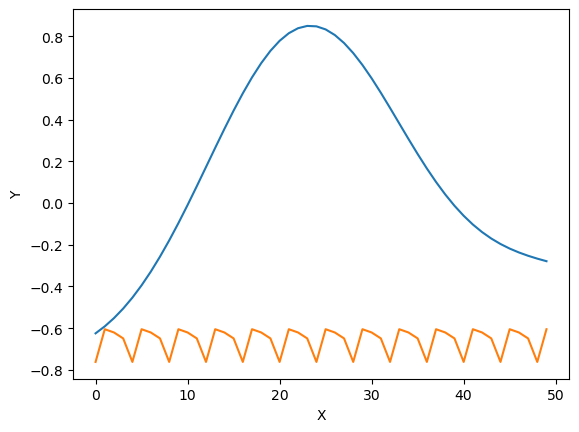

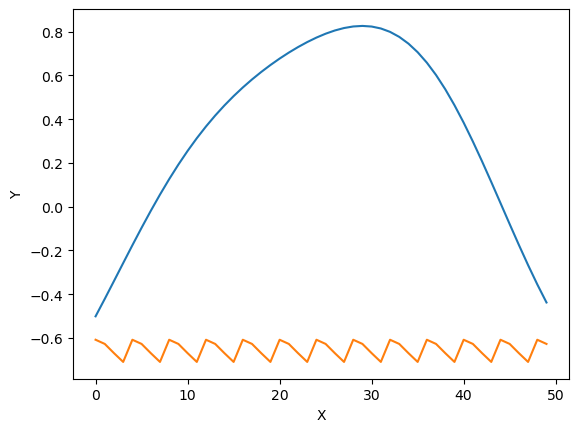

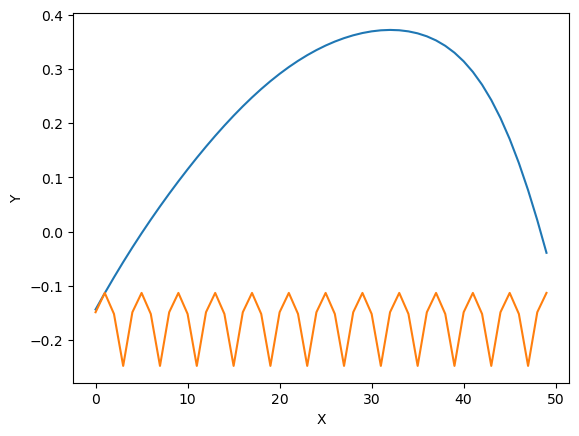

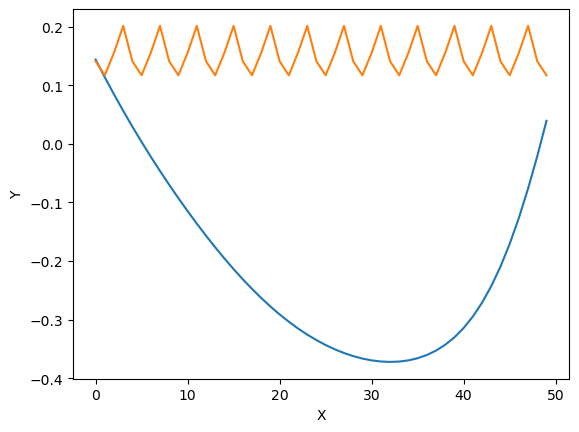

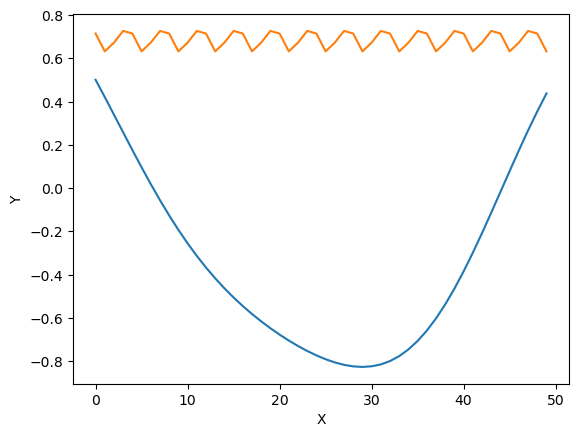

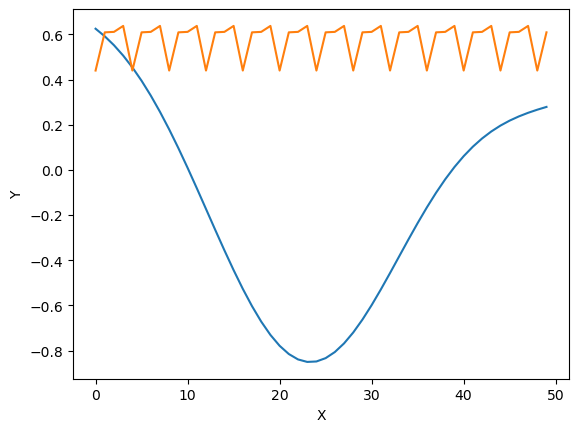

In [ ]:
limit = 50

for particles in range(N-2):
    plt.plot(ml.postprocess(np.array(y_test))[:limit, particles], color="tab:blue")
    plt.plot(ml.postprocess(test_pred)[best_params["window_size"]:limit+best_params["window_size"], particles], color="tab:orange")

    # Set labels and title
    plt.xlabel('X')
    plt.ylabel('Y')
    # plt.ylim(-1.2, 1.2)

    # Show the plot
    plt.show()